# Connecting existing clusters of a bicycle network
## Project: Bicycle network analysis with Gourab, Sayat, Tyler, Michael, Roberta

This notebook takes a city's existing bicycle network, then connects the biggest clusters following greedy triangulation. Code adapted from Tyler.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-29  
Last modified: 2020-07-03

## Preliminaries

### Imports and magics

In [1]:
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import copy
import math
from haversine import haversine
import pprint
import sys
pp = pprint.PrettyPrinter(indent=4)

%matplotlib inline
import pandas as pd
from matplotlib import cm

import watermark
%load_ext watermark

In [2]:
%watermark -n -v -m -g -iv

watermark 2.0.2
igraph    0.8.2
numpy     1.18.4
osmnx     0.13.0
pandas    1.0.3
Fri Jul 03 2020 

CPython 3.8.2
IPython 7.14.0

compiler   : Clang 9.0.1 
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit
Git hash   :


### Parameters

In [51]:
placeid = "budapest"

cutoff = 0.5

datapath = "../data/"
outpath = "../output/"
ymirrored = False

### Functions

In [4]:
# Graph plotting preparation functions
def my_plot_reset(G, nids = False):
    reset_plot_attributes(G)
    color_nodes(G, "red", nids)
    size_nodes(G, 8, nids)

def reset_plot_attributes(G):
    """Resets node attributes for plotting.
    All black and size 0.
    """
    G.vs["color"] = "black"
    G.vs["size"] = 0
        
def color_nodes(G, color = "blue", nids = False, use_id = True):
    """Sets the color attribute of a set of nodes nids.
    """
    if nids is False:
        nids = [v.index for v in G.vs]
        use_id = False
    if use_id:
        for nid in set(nids):
            G.vs.find(id = nid)["color"] = color
    else:
        G.vs[nids]["color"] = color

def size_nodes(G, size = 5, nids = False, use_id = True):
    """Sets the size attribute of a set of nodes nids.
    """
    if nids is False:
        nids = [v.index for v in G.vs]
        use_id = False
    if use_id:
        for nid in set(nids):
            G.vs.find(id = nid)["size"] = size
    else:
        G.vs[nids]["size"] = size

def color_edges(G, color = "blue", eids = False):
    """Sets the color attribute of a set of edge eids.
    """
    if eids is False:
        G.es["color"] = color
    else:
        G.es[eids]["color"] = color
        
def width_edges(G, width = 1, eids = False):
    """Sets the width attribute of a set of edge eids.
    """
    if eids is False:
        G.es["width"] = width
    else:
        G.es[eids]["width"] = width
        
# Other functions   
def round_coordinates(G, r = 7):
    for v in G.vs:
        G.vs[v.index]["x"] = round(G.vs[v.index]["x"], r)
        G.vs[v.index]["y"] = round(G.vs[v.index]["y"], r)

def mirror_y(G):
    for v in G.vs:
        y = G.vs[v.index]["y"]
        G.vs[v.index]["y"] = -y
    
def dist(v1,v2):
    dist = haversine((v1['x'],v1['y']),(v2['x'],v2['y']))
    return dist


def osm_to_ig(node, edge):
    """ Turns a node and edge dataframe into an igraph Graph.
    """
    
    G = ig.Graph(directed = False)

    x_coords = node['x'].tolist() 
    y_coords = node['y'].tolist()
    ids = node['osmid'].tolist()
    coords = []

    for i in range(len(x_coords)):
        G.add_vertex(x = x_coords[i], y = y_coords[i], id = ids[i])
        coords.append((x_coords[i], y_coords[i]))

    id_dict = dict(zip(G.vs['id'], np.arange(0, G.vcount()).tolist()))
    coords_dict = dict(zip(np.arange(0, G.vcount()).tolist(), coords))

    edge_list = []
    for i in range(len(edge)):
        edge_list.append([id_dict.get(edge['u'][i]), id_dict.get(edge['v'][i])])
        
    G.add_edges(edge_list)
    G.simplify()
    new_edges = G.get_edgelist()
    
    distances_list = []
    for i in range(len(new_edges)):
        distances_list.append(haversine(coords_dict.get(new_edges[i][0]), coords_dict.get(new_edges[i][1])))

    G.es()['weight'] = distances_list
    
    return G

## Exploratory Data Analysis

### Load networks

In [5]:
node_biketrack = pd.read_csv(datapath+placeid+'_biketrack_nodes.csv')
edge_biketrack = pd.read_csv(datapath+placeid+'_biketrack_edges.csv')
G_biketrack = osm_to_ig(node_biketrack, edge_biketrack)

node_bikeable = pd.read_csv(datapath+placeid+'_bikeable_nodes.csv')
edge_bikeable = pd.read_csv(datapath+placeid+'_bikeable_edges.csv')
G_bikeable = osm_to_ig(node_bikeable, edge_bikeable)

node_carall = pd.read_csv(datapath+placeid+'_carall_nodes.csv')
edge_carall = pd.read_csv(datapath+placeid+'_carall_edges.csv')
G_carall = osm_to_ig(node_carall, edge_carall)

# Merging biketrack and carall for routing between biketrack clusters
node_biketrackcarall = pd.concat([node_biketrack, node_carall], ignore_index = True, copy=False).drop_duplicates(subset = "osmid").reset_index()
edge_biketrackcarall = pd.concat([edge_biketrack, edge_carall], ignore_index = True, copy=False).reset_index()
G_biketrackcarall = osm_to_ig(node_biketrackcarall, edge_biketrackcarall)

round_coordinates(G_biketrack)
round_coordinates(G_bikeable)
round_coordinates(G_carall)
round_coordinates(G_biketrackcarall)

# This loop is only for plotting, executed once, to mirror all y values
if not ymirrored:
    mirror_y(G_biketrack)
    mirror_y(G_bikeable)
    mirror_y(G_carall)
    mirror_y(G_biketrackcarall)
    ymirrored = True

/Users/misz/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/misz/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
print(len(G_carall.vs), len(G_carall.es))
print(len(G_biketrackcarall.vs), len(G_biketrackcarall.es))
print(len(G_biketrack.vs), len(G_biketrack.es))
print(len(G_biketrackcarall.vs)-len(G_biketrack.vs), len(G_biketrackcarall.es)-len(G_biketrack.es))
node_biketrackcarall["osmid"].is_unique

99263 111342
106592 119822
8686 8574
97906 111248


True

In [ ]:
edge_biketrackcarall.head()

### Plot the starting point

In [ ]:
my_plot_reset(G_biketrack, [])
# ig.plot(G_biketrack, outpath + placeid + '_biketrack.pdf')
# ig.plot(G_biketrack, outpath + placeid + '_biketrack.png', bbox=(800, 800))
ig.plot(G_biketrack, bbox=(400, 300), keep_aspect_ratio = False)

In [ ]:
my_plot_reset(G_bikeable, [])
# ig.plot(G_bikeable, outpath + placeid + '_bikeable.pdf')
# ig.plot(G_bikeable, outpath + placeid + '_bikeable.png', bbox=(800, 800))
ig.plot(G_bikeable, bbox=(400, 300), keep_aspect_ratio = False)

In [ ]:
my_plot_reset(G_carall, [])
# ig.plot(G_bikeable, outpath + placeid + '_bikeable.pdf')
# ig.plot(G_bikeable, outpath + placeid + '_bikeable.png', bbox=(800, 800))
ig.plot(G_carall, bbox=(400, 300), keep_aspect_ratio = False)

In [ ]:
my_plot_reset(G_biketrackcarall, [])
# ig.plot(G_bikeable, outpath + placeid + '_bikeable.pdf')
# ig.plot(G_bikeable, outpath + placeid + '_bikeable.png', bbox=(800, 800))
ig.plot(G_biketrackcarall, bbox=(400, 300), keep_aspect_ratio = False)

### Cluster analysis

#### Cluster functions

In [41]:
def highest_closeness_node(G):
    closeness_values = G.closeness(weights = 'weight')
    sorted_closeness = sorted(closeness_values, reverse = True)
    index = closeness_values.index(sorted_closeness[0])
    return G.vs(index)['id']

def clusterindices_by_length(clusterinfo, rev = True):
    return [k for k, v in sorted(clusterinfo.items(), key=lambda item: item[1]["length"], reverse = rev)]

class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
def ccw(A,B,C):
    return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

def segments_intersect(A,B,C,D):
    """Check if two line segments intersect (except for colinearity)
    Returns true if line segments AB and CD intersect properly.
    Adapted from: https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect
    """
    if (A.x == C.x and A.y == C.y) or (A.x == D.x and A.y == D.y) or (B.x == C.x and B.y == C.y) or (B.x == D.x and B.y == D.y): return False # If the segments share an endpoint they do not intersect properly
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def new_edge_intersects(G, enew):
    """Given a graph G and a potential new edge enew,
    check if enew will intersect any old edge.
    """
    E1 = Point(enew[0], enew[1])
    E2 = Point(enew[2], enew[3])
    for e in G.es():
        O1 = Point(e.source_vertex["x"], e.source_vertex["y"])
        O2 = Point(e.target_vertex["x"], e.target_vertex["y"])
        if segments_intersect(E1, E2, O1, O2):
            return True
    return False
    

def delete_overlaps(G_res, G_orig):
    """Deletes all overlaps of G_res with G_orig (from G_res)
    based on node ids.
    """
    cnt_e = 0
    for e in list(G_res.es):
        try:
            n1_id = e.source_vertex["id"]
            n2_id = e.target_vertex["id"]
            # If there is already an edge in the original network, delete it
            n1_index = G_orig.vs.find(id = n1_id).index
            n2_index = G_orig.vs.find(id = n2_id).index
            if G_orig.are_connected(n1_index, n2_index):
                G_res.delete_edges(e)
                cnt_e += 1
        except:
            pass
    # Remove isolated nodes
    isolated_nodes = G_res.vs.select(_degree_eq=0)
    G_res.delete_vertices(isolated_nodes)
    print("Removed " + str(cnt_e) + " overlapping edges and " + str(len(isolated_nodes)) + " nodes.")


def greedy_triangulation(GT, poipairs, betweenness_quantile = 1):
    """Greedy Triangulation (GT) of a graph GT with an empty edge set.
    Distances between pairs of nodes are given by poipairs.
    
    The GT connects pairs of nodes in ascending order of their distance provided
    that no edge crossing is introduced. It leads to a maximal connected planar
    graph, while minimizing the total length of edges considered. 
    See: cardillo2006spp
    """
    
    for poipair, poipair_distance in poipairs:
        poipair_ind = (GT.vs.find(id = poipair[0]).index, GT.vs.find(id = poipair[1]).index)
        if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
            GT.add_edge(poipair_ind[0], poipair_ind[1], weight = poipair_distance)
            
    # Get betweenness for prioritization
    BW = GT.edge_betweenness(False, None, "weight")
    qt = np.quantile(BW, 1-betweenness_quantile)
    sub_edges = []
    for c, e in enumerate(GT.es):
        if BW[c] >= qt: 
            sub_edges.append(c)
        GT.es[c]["bw"] = BW[c]
        GT.es[c]["width"] = math.sqrt(BW[c]+1)*0.5
    # Prune
    GT = GT.subgraph_edges(sub_edges)
    
    return GT
    

def greedy_triangulation_routing_clusters(G, G_total, clusters, clusterinfo, verbose = False, full_run = False):
    """Greedy Triangulation (GT) of a bike network G's clusters,
    then routing on the graph G_total that includes car infra to connect the GT.
    G and G_total are ipgraph graphs
    
    The GT connects pairs of clusters in ascending order of their distance provided
    that no edge crossing is introduced. It leads to a maximal connected planar
    graph, while minimizing the total length of edges considered. 
    See: cardillo2006spp
    
    Distance here is routing distance, while edge crossing is checked on an abstract 
    level.
    """
    
    # GT is the Graph with the routing of the greedy triangulation
    GT_indices = set()
    
    centroid_indices = [v["centroid_index"] for k, v in sorted(clusterinfo.items(), key=lambda item: item[1]["size"], reverse = True)]
        
    G_temp = copy.deepcopy(G_total)
    for e in G_temp.es: # delete all edges
        G_temp.es.delete(e)
    GT_abstract = G_temp.subgraph(centroid_indices)
    
    clusterpairs = clusterpairs_by_distance(G, G_total, clusters, clusterinfo, True, verbose, full_run)
    
    centroidpairs = [((clusterinfo[c[0][0]]['centroid_id'], clusterinfo[c[0][1]]['centroid_id']), c[2]) for c in clusterpairs]
    
    GT_abstract = greedy_triangulation(GT_abstract, centroidpairs)
    
    centroidids_closestnodeids = {} # dict for retrieveing quickly closest node ids pairs from centroidid pairs
    for x in clusterpairs:
        centroidids_closestnodeids[(clusterinfo[x[0][0]]["centroid_id"], clusterinfo[x[0][1]]["centroid_id"])] = (x[1][0], x[1][1])
        centroidids_closestnodeids[(clusterinfo[x[0][1]]["centroid_id"], clusterinfo[x[0][0]]["centroid_id"])] = (x[1][1], x[1][0]) # also add switched version as we do not care about order
        
    # Get node pairs we need to route, sorted by distance
    routenodepairs = []
    for e in GT_abstract.es:
        # get the centroid-ids from closestnode-ids
        routenodepairs.append([centroidids_closestnodeids[(e.source_vertex["id"], e.target_vertex["id"])], e["weight"]])
        
    routenodepairs.sort(key=lambda x: x[1])
#     pp.pprint(routenodepairs)
    
    # Do the routing, on G_total
    for poipair, poipair_distance in routenodepairs:
        poipair_ind = (G_total.vs.find(id = poipair[0]).index, G_total.vs.find(id = poipair[1]).index)
        sp = set(G_total.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights = "weight", output = "vpath")[0])
        GT_indices = GT_indices.union(sp)

    GT = G_total.induced_subgraph(GT_indices)
    
    return(GT, GT_abstract)


def clusterpairs_by_distance(G, G_total, clusters, clusterinfo, return_distances = False, verbose = False, full_run = False):
    """Calculates the (weighted) graph distances on G for a number of clusters.
    Returns all pairs of cluster ids and closest nodes in ascending order of their distance. 
    If return_distances, then distances are also returned.

    Returns a list containing these elements, sorted by distance:
    [(clusterid1, clusterid2), (closestnodeid1, closestnodeid2), distance]
    """
    
    cluster_indices = clusterindices_by_length(clusterinfo, False) # Start with the smallest so the for loop is as short as possible
    clusterpairs = []
    clustercopies = {}
    
    # Create copies of all clusters
    for i in range(len(cluster_indices)):
        clustercopies[i] = clusters[i].copy()
        
    # Take one cluster
    for i, c1 in enumerate(cluster_indices[:-1]):
        c1_indices = G_total.vs.select(lambda x: x["id"] in clustercopies[c1].vs()["id"]).indices
        print("Working on cluster " + str(i+1) + " of " + str(len(cluster_indices)) + "...")
        for j, c2 in enumerate(cluster_indices[i+1:]):
            closest_pair = {'i': 0, 'j': 0}
            min_dist = np.inf
            c2_indices = G_total.vs.select(lambda x: x["id"] in clustercopies[c2].vs()["id"]).indices
            if verbose: print("... routing " + str(len(c1_indices)) + " nodes to " + str(len(c2_indices)) + " nodes in other cluster " + str(j+1) + " of " + str(len(cluster_indices[i+1:])) + ".")
            
            if full_run:
                # Compare all pairs of nodes in both clusters (takes long)
                for a in list(c1_indices):
                    sp = G_total.get_shortest_paths(a, c2_indices, weights = "weight", output = "epath")

                    if all([not elem for elem in sp]):
                        # If there is no path from one node, there is no path from any node
                        break
                    else:
                        for path, c2_index in zip(sp, c2_indices):
                            if len(path) >= 1:
                                dist_nodes = sum([G_total.es[e]['weight'] for e in path])
                                if dist_nodes < min_dist:
                                    closest_pair['i'] = G_total.vs[a]["id"]
                                    closest_pair['j'] = G_total.vs[c2_index]["id"]
                                    min_dist = dist_nodes
            else:
                # Do a heuristic that should be close enough.
                # From cluster 1, look at all shortest paths only from its centroid
                a = clusterinfo[c1]["centroid_index"]
                sp = G_total.get_shortest_paths(a, c2_indices, weights = "weight", output = "epath")
                if all([not elem for elem in sp]):
                    # If there is no path from one node, there is no path from any node
                    break
                else:
                    for path, c2_index in zip(sp, c2_indices):
                        if len(path) >= 1:
                            dist_nodes = sum([G_total.es[e]['weight'] for e in path])
                            if dist_nodes < min_dist:
                                closest_pair['j'] = G_total.vs[c2_index]["id"]
                                min_dist = dist_nodes
                # Closest c2 node to centroid1 found. Now find all c1 nodes to that closest c2 node.
                b = G_total.vs.find(id = closest_pair['j']).index
                sp = G_total.get_shortest_paths(b, c1_indices, weights = "weight", output = "epath")
                if all([not elem for elem in sp]):
                    # If there is no path from one node, there is no path from any node
                    break
                else:
                    for path, c1_index in zip(sp, c1_indices):
                        if len(path) >= 1:
                            dist_nodes = sum([G_total.es[e]['weight'] for e in path])
                            if dist_nodes < min_dist:
                                closest_pair['i'] = G_total.vs[c1_index]["id"]
                                min_dist = dist_nodes
            clusterpairs.append([(c1, c2), (closest_pair['i'], closest_pair['j']), min_dist])
                                    
    clusterpairs.sort(key = lambda x: x[-1])
    if return_distances:
        return clusterpairs
    else:
        return [[o[0], o[1]] for o in clusterpairs]

In [42]:
G = copy.deepcopy(G_biketrack) # G is the bike graph we are working with

In [52]:
clusters = []
clusterinfo = {}
i = 0
total_length = sum(G.es["weight"])
for j in range(len(list(G.components()))):
    if len(list(G.components())[j]) > 1:
        clusterinfo[i] = {"size": G.subgraph(list(G.components())[j]).vcount(), 
                          "centroid_id": highest_closeness_node(G.subgraph(list(G.components())[j]))[0],
                          "length": sum(G.subgraph(list(G.components())[j]).es["weight"])
                          }
        clusterinfo[i]["centroid_index"] = G.vs.find(id = clusterinfo[i]['centroid_id']).index
        i += 1


cluster_indices = clusterindices_by_length(clusterinfo)

clusterinfo_temp = {}
length_covered = 0
i = 0
for c in cluster_indices:
    clusters.append(G.subgraph(list(G.components())[c]))
    clusterinfo_temp[i] = clusterinfo[c]
    length_covered += clusterinfo[c]["length"]
    if length_covered >= cutoff*total_length:
        break
    i += 1

print('{:d}'.format(i+1) + " largest clusters of " + '{:d}'.format(len(list(G.components()))) + " considered. Length covered: " + '{:.2f}'.format(length_covered) + " km (" + '{:.0f}'.format(100*length_covered/total_length) + "% of total length)")

clusterinfo = copy.deepcopy(clusterinfo_temp)

cluster_indices = clusterindices_by_length(clusterinfo)

12 largest clusters of 192 considered. Length covered: 136.38 km (51% of total length)


In [ ]:
# pp.pprint(clusterinfo)

plt.figure(figsize=[2*6.4, 2*4.8])
for i in range(len(clusters)):
    plt.plot(clusters[i].vs['x'],clusters[i].vs['y'],'.')
plt.gca().invert_yaxis()
%config InlineBackend.figure_format = 'retina'

In [ ]:
# # For testing
# # Get the pairs of distances between all clusters, where distance is routing distance of the closest nodes
# clusterpairs = clusterpairs_by_distance(G, G_biketrackcarall, clusters, clusterinfo, True, True, False)
# clusterpairs

In [17]:
# # For testing
# temp_list = set()
# for x in clusterpairs:
#     temp_list.add(x[1][0])
#     temp_list.add(x[1][1])
# temp_list = list(temp_list)
# temp_list
# my_plot_reset(G_biketrack, temp_list)
# ig.plot(G_biketrack)

In [54]:
GT, GT_abstract = greedy_triangulation_routing_clusters(G, G_biketrackcarall, clusters, clusterinfo)

Working on cluster 1 of 12...


<ipython-input-41-cb415e7d7076>:195: RuntimeWarning: Couldn't reach some vertices at /Users/runner/miniforge3/conda-bld/python-igraph_1588168241529/work/vendor/source/igraph/src/structural_properties.c:4726
  sp = G_total.get_shortest_paths(a, c2_indices, weights = "weight", output = "epath")


Working on cluster 2 of 12...
Working on cluster 3 of 12...
Working on cluster 4 of 12...
Working on cluster 5 of 12...
Working on cluster 6 of 12...
Working on cluster 7 of 12...
Working on cluster 8 of 12...
Working on cluster 9 of 12...
Working on cluster 10 of 12...
Working on cluster 11 of 12...


In [55]:
delete_overlaps(GT, G_biketrack)

Removed 39 overlapping edges and 15 nodes.


In [47]:
# ig.plot(GT_abstract)
GT_abstract.vcount()

5

### Plot just the clusters and their new connections

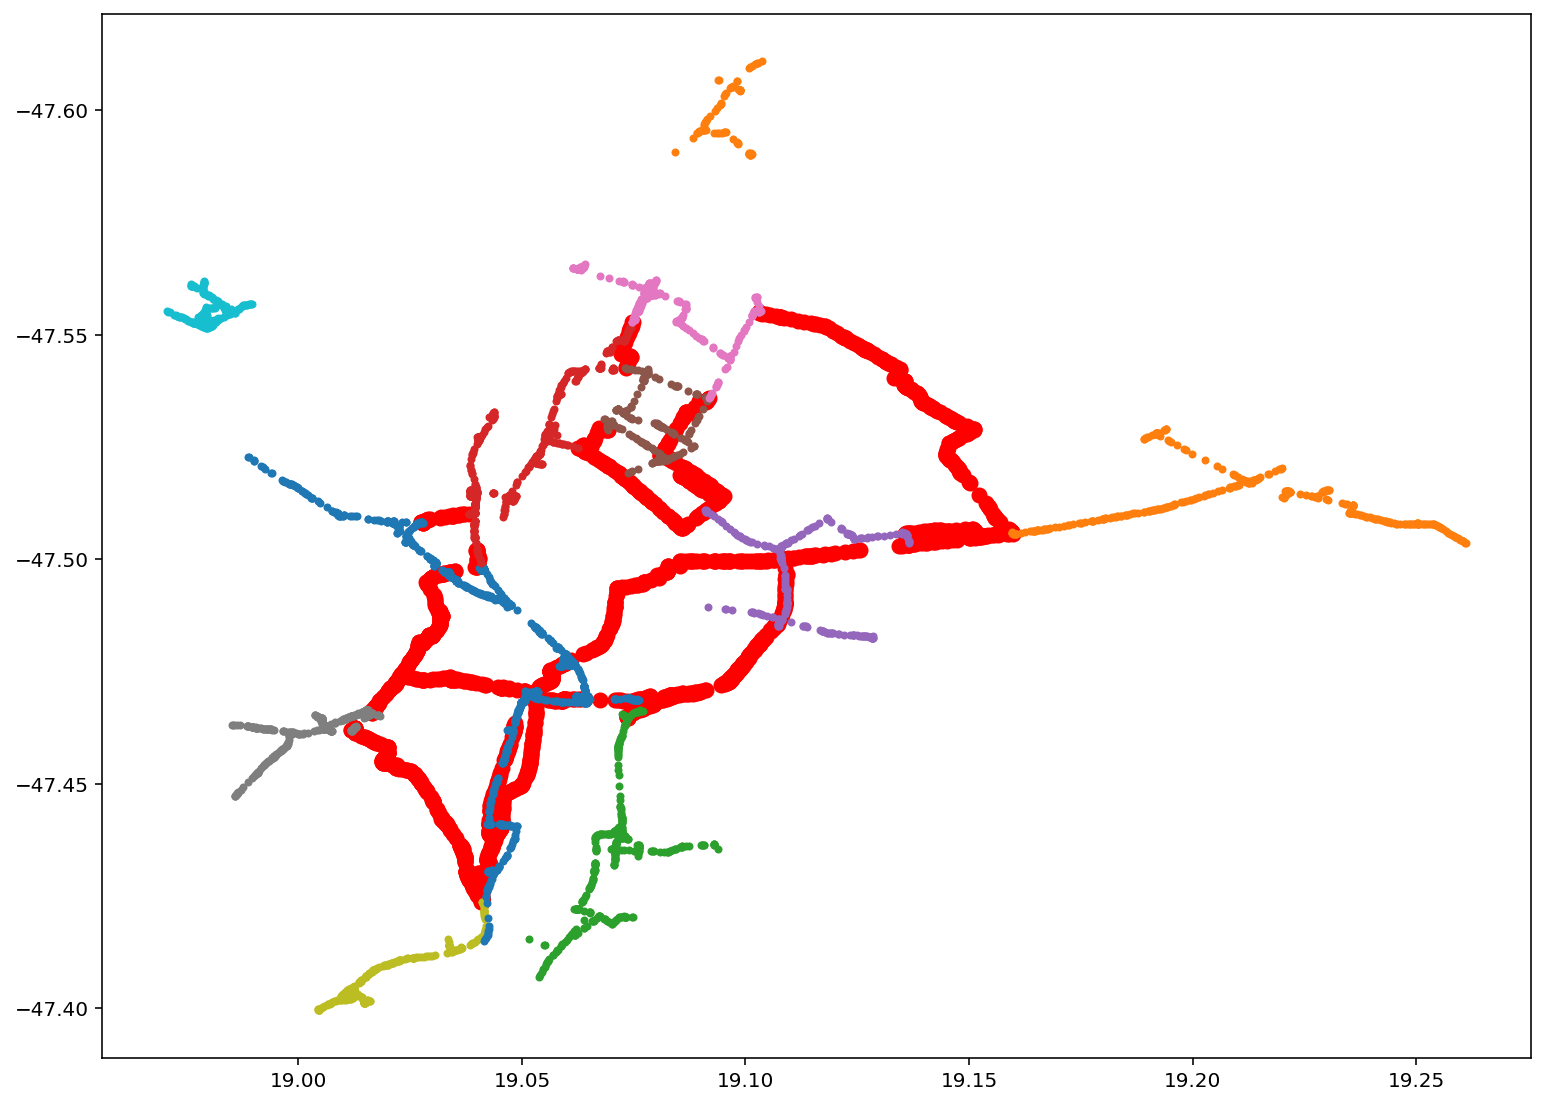

In [56]:
plt.figure(figsize=[2*6.4, 2*4.8])
plt.plot(GT.vs['x'], GT.vs['y'], 'o', color='red', markersize=7)
for i in range(len(clusters)):
    plt.plot(clusters[i].vs['x'], clusters[i].vs['y'],'.')
plt.gca().invert_yaxis()
%config InlineBackend.figure_format = 'retina'

### Plot just the new connections

In [ ]:
size_nodes(GT, 0)
width_edges(GT, 2)
color_edges(GT, "blue")

ig.plot(GT)

### Plot the whole bike network and its new connections

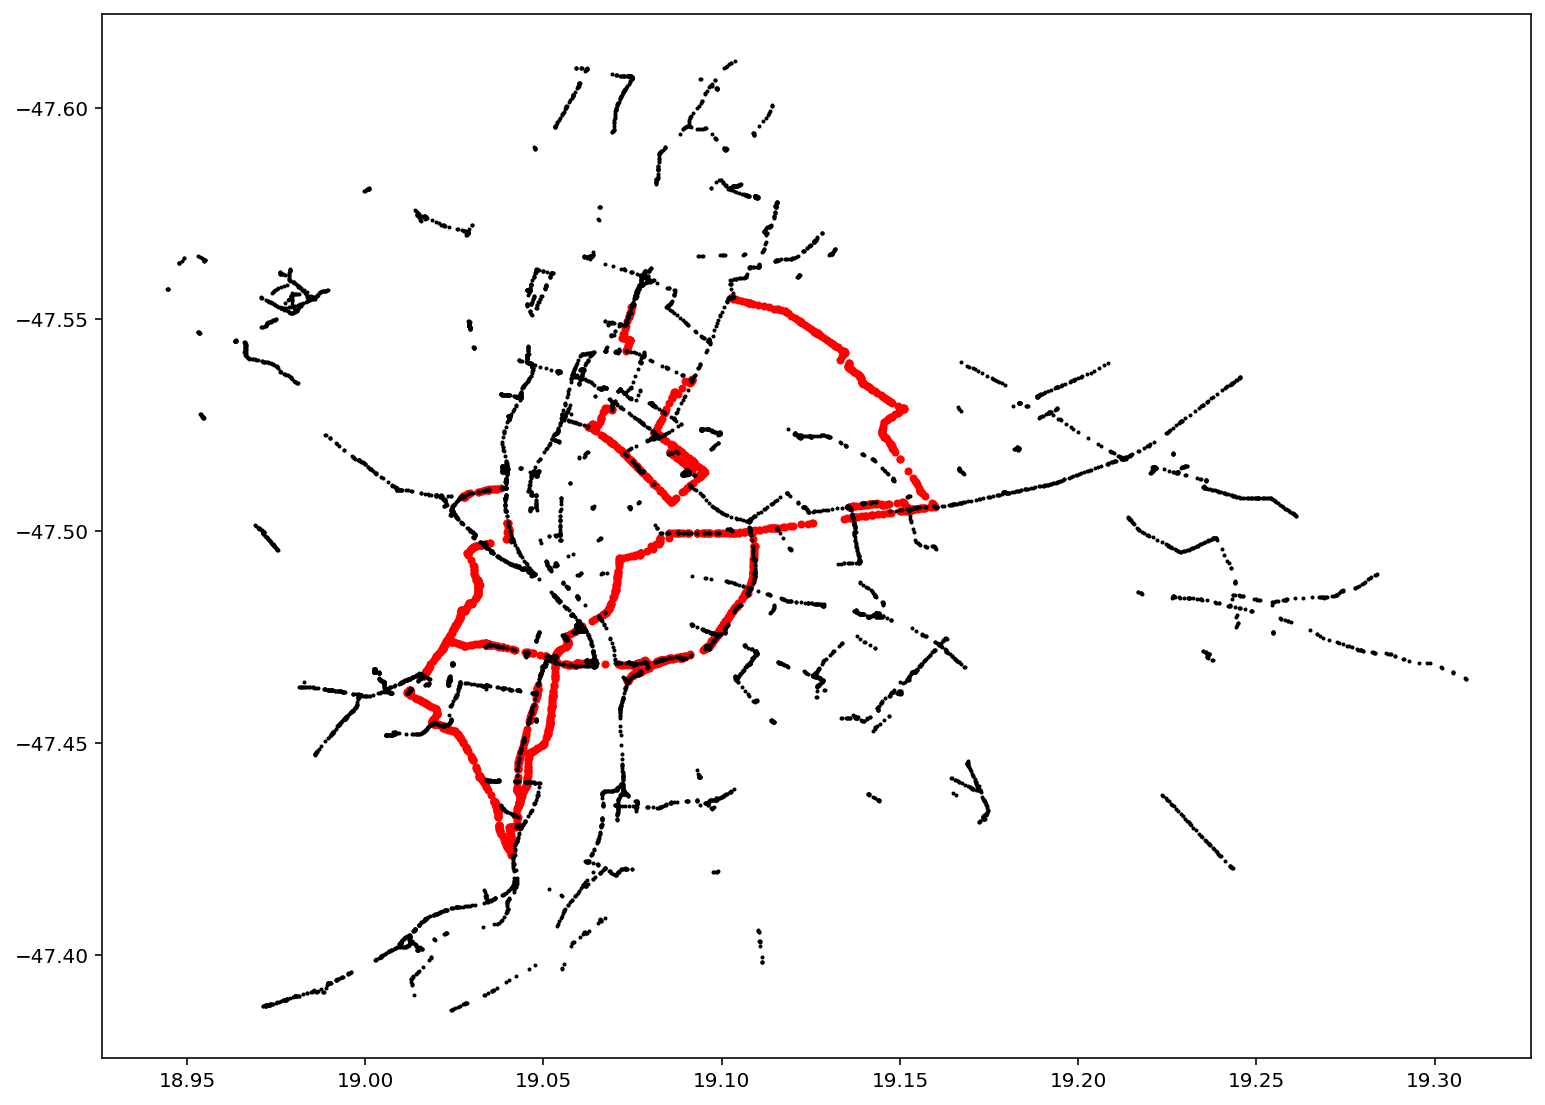

In [58]:
plt.figure(figsize=[2*6.4, 2*4.8])
plt.plot(GT.vs['x'], GT.vs['y'], 'o', color='red', markersize=3)
plt.plot(G_biketrack.vs['x'], G_biketrack.vs['y'], 'o', color='black', markersize=1)
plt.gca().invert_yaxis()
%config InlineBackend.figure_format = 'retina'

# plt.figure(figsize=[2*6.4, 2*4.8])
# plt.plot(GT.vs['x'], GT.vs['y'], 'o', color='red', markersize=3)
# plt.plot(G_bikeable.vs['x'], G_bikeable.vs['y'], 'o', color='grey', markersize=1)
# plt.gca().invert_yaxis()
# %config InlineBackend.figure_format = 'retina'